# GAN

## Import packages

In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

import cv2
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Config (You can change)

In [12]:
CUDA = True
DATA_PATH = './data'
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 20
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

In [13]:
CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
print(device)
cudnn.benchmark = True

PyTorch version: 2.3.0+cu121
CUDA version: 12.1

cuda:0


## Prepare data

In [ ]:
# Data preprocessing
dataset = dset.MNIST(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15896441.19it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 481027.43it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4429283.04it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3830021.87it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



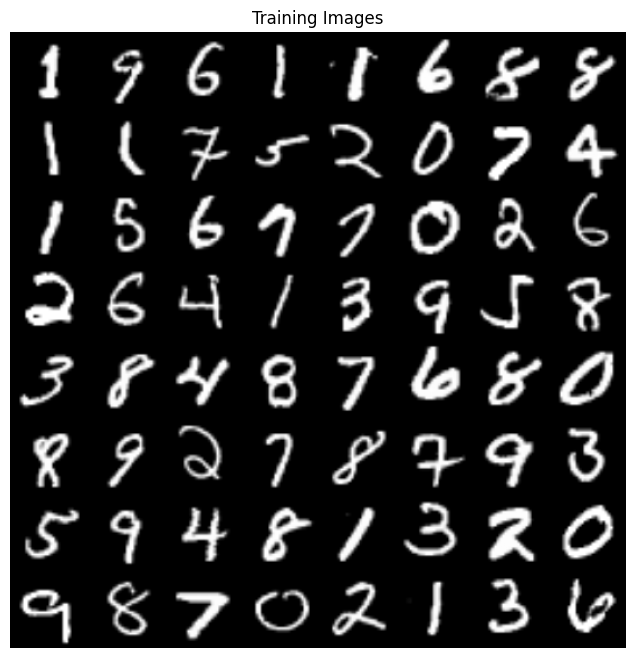

In [ ]:
# Plot training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## GAN Architecture (You can change)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # output layer
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [ ]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Training (You can change)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [8]:
# Function to clear the directory before training
def clear_directory(directory):
    """
    Remove all files from the given directory.

    :param directory: str, path to the directory to be cleared
    """
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

### Training GANs

In [ ]:
from PIL import Image

# Define directories to save images
real_images_dir = "gan_real_images"
fake_images_dir = "gan_fake_images"

# Create directories if they do not exist
os.makedirs(real_images_dir, exist_ok=True)
os.makedirs(fake_images_dir, exist_ok=True)

# Clear the directories before saving new images
clear_directory(real_images_dir)
clear_directory(fake_images_dir)

# Define a transform to convert a tensor to a PIL image
to_pil_image = transforms.ToPILImage()

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):
        # (1) Update the discriminator with real data
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # (3) Update the generator with fake data
        netG.zero_grad()
        label.fill_(REAL_LABEL)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        # Save individual real images (only need to save once)
        if iters == 0:
            for idx in range(real_cpu.size(0)):
                img = to_pil_image(real_cpu[idx].cpu())
                img.save(f"{real_images_dir}/real_image_{idx}.png")

        iters += 1

    # Save individual fake images only at the end of the last epoch
    if epoch == EPOCH_NUM - 1:
        with torch.no_grad():
            fake = netG(viz_noise).detach().cpu()
            for k in range(fake.size(0)):
                img = to_pil_image(fake[k])
                img.save(f"{fake_images_dir}/fake_image_{k}.png")

Starting Training Loop...
[0/20][0/469]	Loss_D: 2.1441	Loss_G: 2.8085	D(x): 0.3874	D(G(z)): 0.5914 / 0.0823
[0/20][50/469]	Loss_D: 0.0306	Loss_G: 18.1069	D(x): 0.9828	D(G(z)): 0.0000 / 0.0000
[0/20][100/469]	Loss_D: 0.2132	Loss_G: 4.9595	D(x): 0.9240	D(G(z)): 0.1116 / 0.0106
[0/20][150/469]	Loss_D: 0.2257	Loss_G: 4.1515	D(x): 0.9374	D(G(z)): 0.1307 / 0.0224
[0/20][200/469]	Loss_D: 2.0772	Loss_G: 1.0095	D(x): 0.2796	D(G(z)): 0.0106 / 0.4731
[0/20][250/469]	Loss_D: 1.0736	Loss_G: 7.7396	D(x): 0.9773	D(G(z)): 0.5870 / 0.0011
[0/20][300/469]	Loss_D: 0.9603	Loss_G: 9.9969	D(x): 0.9965	D(G(z)): 0.5285 / 0.0001
[0/20][350/469]	Loss_D: 0.2527	Loss_G: 2.9176	D(x): 0.8205	D(G(z)): 0.0317 / 0.0777
[0/20][400/469]	Loss_D: 2.7110	Loss_G: 17.2157	D(x): 0.9985	D(G(z)): 0.8844 / 0.0000
[0/20][450/469]	Loss_D: 0.1834	Loss_G: 3.1049	D(x): 0.9182	D(G(z)): 0.0858 / 0.0625
[1/20][0/469]	Loss_D: 0.1609	Loss_G: 2.8346	D(x): 0.9399	D(G(z)): 0.0889 / 0.0767
[1/20][50/469]	Loss_D: 0.2749	Loss_G: 2.0643	D(x): 0.

### FID score on each images

In [ ]:
calculate_fid(fake_images_dir, real_images_dir)

1/1 [==============================] - 0s 36ms/step


240.21484777019353

### FID score image by image

In [ ]:
# Define directories to save images
real_image_dir = "gan_real_images/real_image_0.png"
fake_image_dir = "gan_fake_images/fake_image_102.png"

calculate_fid_between_images(real_image_dir, fake_image_dir)

### Plot losses of G & D

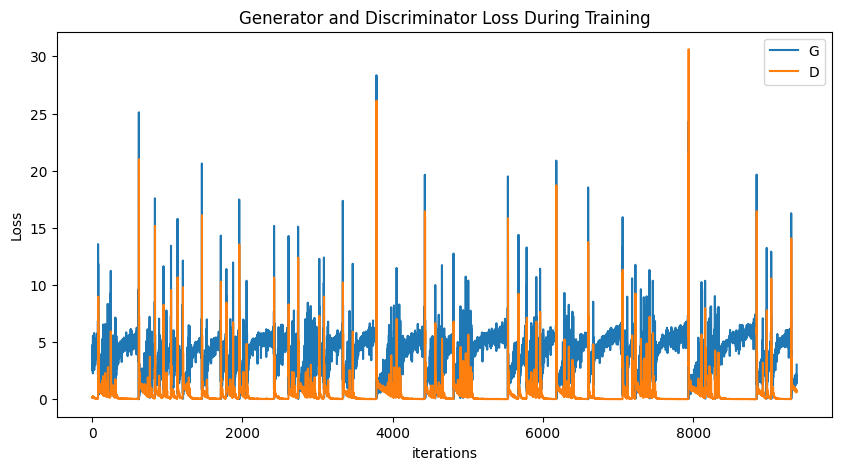

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Plot the results

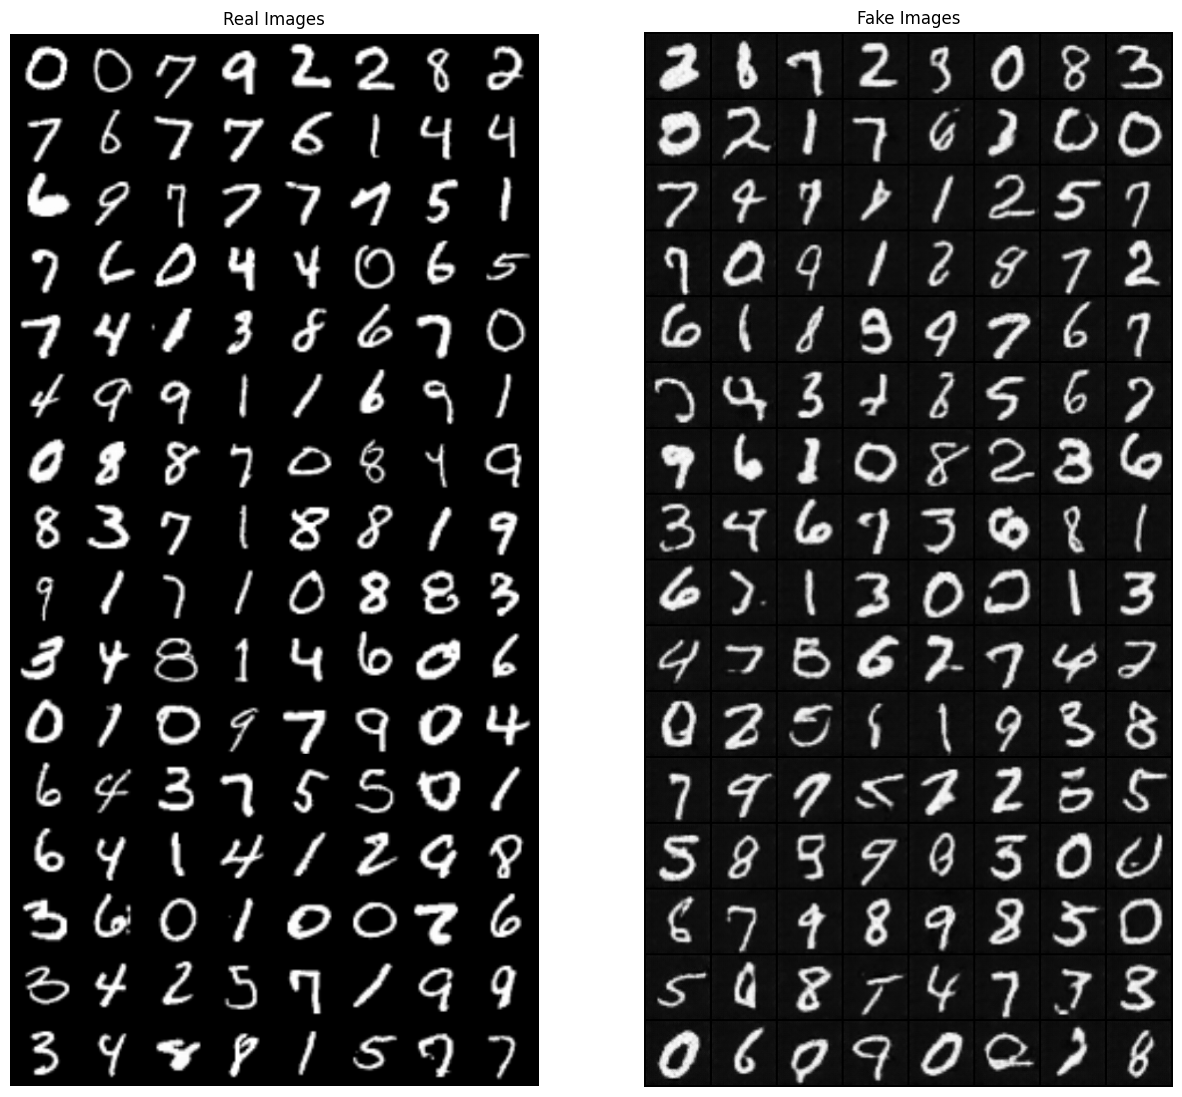

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:128], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Diffusion model

## Import packages

In [2]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.datasets.mnist import load_data
import math

## Architecture of Diffusion model

In [3]:
def get_timestep_embedding(timesteps, embedding_dim: int):
    """
    Retrieved from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py#LL90C1-L109C13
    """
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
    emb = timesteps.type(torch.float32)[:, None] * emb[None, :]
    emb = torch.concat([torch.sin(emb), torch.cos(emb)], axis=1)

    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.pad(emb, [[0, 0], [0, 1]])

    assert emb.shape == (timesteps.shape[0], embedding_dim), f"{emb.shape}"
    return emb


class Downsample(nn.Module):

    def __init__(self, C):
        """
        :param C (int): number of input and output channels
        """
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, stride=2, padding=1)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.conv(x)
        assert x.shape == (B, C, H // 2, W // 2)
        return x


class Upsample(nn.Module):

    def __init__(self, C):
        """
        :param C (int): number of input and output channels
        """
        super(Upsample, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, stride=1, padding=1)

    def forward(self, x):
        B, C, H, W = x.shape

        x = nn.functional.interpolate(x, size=None, scale_factor=2, mode='nearest')

        x = self.conv(x)
        assert x.shape == (B, C, H * 2, W * 2)
        return x


class Nin(nn.Module):

    def __init__(self, in_dim, out_dim, scale=1e-10):
        super(Nin, self).__init__()

        n = (in_dim + out_dim) / 2
        limit = np.sqrt(3 * scale / n)
        self.W = torch.nn.Parameter(torch.zeros((in_dim, out_dim), dtype=torch.float32
                                                ).uniform_(-limit, limit))
        self.b = torch.nn.Parameter(torch.zeros((1, out_dim, 1, 1), dtype=torch.float32))

    def forward(self, x):
        return torch.einsum('bchw, co->bowh', x, self.W) + self.b


class ResNetBlock(nn.Module):

    def __init__(self, in_ch, out_ch, dropout_rate=0.1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
        self.dense = nn.Linear(512, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1)

        if not (in_ch == out_ch):
            self.nin = Nin(in_ch, out_ch)

        self.dropout_rate = dropout_rate
        self.nonlinearity = torch.nn.SiLU()

    def forward(self, x, temb):
        """
        :param x: (B, C, H, W)
        :param temb: (B, dim)
        """

        h = self.nonlinearity(nn.functional.group_norm(x, num_groups=32))
        h = self.conv1(h)

        # add in timestep embedding
        h += self.dense(self.nonlinearity(temb))[:, :, None, None]

        h = self.nonlinearity(nn.functional.group_norm(h, num_groups=32))
        h = nn.functional.dropout(h, p=self.dropout_rate)
        h = self.conv2(h)

        if not (x.shape[1] == h.shape[1]):
            x = self.nin(x)

        assert x.shape == h.shape
        return x + h


class AttentionBlock(nn.Module):

    def __init__(self, ch):
        super(AttentionBlock, self).__init__()

        self.Q = Nin(ch, ch)
        self.K = Nin(ch, ch)
        self.V = Nin(ch, ch)

        self.ch = ch

        self.nin = Nin(ch, ch, scale=0.)

    def forward(self, x):
        B, C, H, W = x.shape
        assert C == self.ch

        h = nn.functional.group_norm(x, num_groups=32)
        q = self.Q(h)
        k = self.K(h)
        v = self.V(h)

        w = torch.einsum('bchw,bcHW->bhwHW', q, k) * (int(C) ** (-0.5))  # [B, H, W, H, W]
        w = torch.reshape(w, [B, H, W, H * W])
        w = torch.nn.functional.softmax(w, dim=-1)
        w = torch.reshape(w, [B, H, W, H, W])

        h = torch.einsum('bhwHW,bcHW->bchw', w, v)
        h = self.nin(h)

        assert h.shape == x.shape
        return x + h


class UNet(nn.Module):

    def __init__(self, ch=128, in_ch=1):
        super(UNet, self).__init__()

        self.ch = ch
        self.linear1 = nn.Linear(ch, 4 * ch)
        self.linear2 = nn.Linear(4 * ch, 4 * ch)

        self.conv1 = nn.Conv2d(in_ch, ch, 3, stride=1, padding=1)

        self.down = nn.ModuleList([ResNetBlock(ch, 1 * ch),
                                   ResNetBlock(1 * ch, 1 * ch),
                                   Downsample(1 * ch),
                                   ResNetBlock(1 * ch, 2 * ch),
                                   AttentionBlock(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   AttentionBlock(2 * ch),
                                   Downsample(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   Downsample(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch)])

        self.middle = nn.ModuleList([ResNetBlock(2 * ch, 2 * ch),
                                     AttentionBlock(2 * ch),
                                     ResNetBlock(2 * ch, 2 * ch)])

        self.up = nn.ModuleList([ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 ResNetBlock(3 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(3 * ch, ch),
                                 ResNetBlock(2 * ch, ch),
                                 ResNetBlock(2 * ch, ch)])

        self.final_conv = nn.Conv2d(ch, in_ch, 3, stride=1, padding=1)

    def forward(self, x, t):
        """
        :param x: (torch.Tensor) batch of images [B, C, H, W]
        :param t: (torch.Tensor) tensor of time steps (torch.long) [B]
        """

        temb = get_timestep_embedding(t, self.ch)
        temb = torch.nn.functional.silu(self.linear1(temb))
        temb = self.linear2(temb)
        assert temb.shape == (t.shape[0], self.ch * 4)

        x1 = self.conv1(x)

        # Down
        x2 = self.down[0](x1, temb)
        x3 = self.down[1](x2, temb)
        x4 = self.down[2](x3)
        x5 = self.down[3](x4, temb)
        x6 = self.down[4](x5)  # Attention
        x7 = self.down[5](x6, temb)
        x8 = self.down[6](x7)  # Attention
        x9 = self.down[7](x8)
        x10 = self.down[8](x9, temb)
        x11 = self.down[9](x10, temb)
        x12 = self.down[10](x11)
        x13 = self.down[11](x12, temb)
        x14 = self.down[12](x13, temb)

        # Middle
        x = self.middle[0](x14, temb)
        x = self.middle[1](x)
        x = self.middle[2](x, temb)

        # Up
        x = self.up[0](torch.cat((x, x14), dim=1), temb)
        x = self.up[1](torch.cat((x, x13), dim=1), temb)
        x = self.up[2](torch.cat((x, x12), dim=1), temb)
        x = self.up[3](x)
        x = self.up[4](torch.cat((x, x11), dim=1), temb)
        x = self.up[5](torch.cat((x, x10), dim=1), temb)
        x = self.up[6](torch.cat((x, x9), dim=1), temb)
        x = self.up[7](x)
        x = self.up[8](torch.cat((x, x8), dim=1), temb)
        x = self.up[9](x)
        x = self.up[10](torch.cat((x, x6), dim=1), temb)
        x = self.up[11](x)
        x = self.up[12](torch.cat((x, x4), dim=1), temb)
        x = self.up[13](x)
        x = self.up[14](x)
        x = self.up[15](torch.cat((x, x3), dim=1), temb)
        x = self.up[16](torch.cat((x, x2), dim=1), temb)
        x = self.up[17](torch.cat((x, x1), dim=1), temb)

        x = nn.functional.silu(nn.functional.group_norm(x, num_groups=32))
        x = self.final_conv(x)

        return x

## Diffusion model class

In [4]:
def sample_batch(batch_size, device):
    indices = torch.randperm(trainX.shape[0])[:batch_size]
    data = torch.from_numpy(trainX[indices]).unsqueeze(1).to(device)
    return torch.nn.functional.interpolate(data, 32)


class DiffusionModel:
    def __init__(self, T: int, model: nn.Module, device: str):
        """ Constructor """

        self.T = T                                     # Number of diffusion steps
        self.function_approximator = model.to(device)  # Diffusion approximation model
        self.device = device

        # Compute alpha and beta for each step
        self.beta = torch.linspace(1e-4, 0.02, T).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def training(self, batch_size, optimizer):
        # Samples a batch of data and a sampling time t for each item in the batch
        x0 = sample_batch(batch_size, self.device)
        t = torch.randint(1, self.T + 1, (batch_size,), device=self.device,
                          dtype=torch.long)
        eps = torch.randn_like(x0)

        # Gradient descent
        alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(
            -1).unsqueeze(-1)
        eps_predicted = self.function_approximator(torch.sqrt(
            alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * eps, t - 1)

        # Loss function
        loss = nn.functional.mse_loss(eps, eps_predicted)

        # Backpropagation and weights update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    @torch.no_grad()
    def sampling(self, n_samples=1, image_channels=1, img_size=(32, 32),
                 use_tqdm=True):
        # Samples from diffusion model
        x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]),
                        device=self.device)
        progress_bar = tqdm if use_tqdm else lambda x: x

        for t in progress_bar(range(self.T, 0, -1)):
            z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
            t = torch.ones(n_samples, dtype=torch.long, device=self.device) * t

            # Compute features from step t
            beta_t = self.beta[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_t = self.alpha[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

            # Sample of x at step t
            mean = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / torch.sqrt(
                1 - alpha_bar_t)) * self.function_approximator(x, t - 1))
            sigma = torch.sqrt(beta_t)
            x = mean + sigma * z

        return x

In [23]:
from PIL import Image

# Define directories to save images
real_images_dir = "diffusion_model_real_images"
fake_images_dir = "diffusion_model_fake_images"

# Create directories if they do not exist
os.makedirs(real_images_dir, exist_ok=True)
os.makedirs(fake_images_dir, exist_ok=True)

# Clear the directories before saving new images
clear_directory(real_images_dir)
clear_directory(fake_images_dir)

# dataset
(trainX, trainy), (testX, testy) = load_data()
trainX = np.float32(trainX) / 255.
testX = np.float32(testX) / 255.

# Save true MNIST images
for i, img in enumerate(trainX[:100]):  # Save the first 100 images for example
    img_array = (img * 255).astype(np.uint8)
    img = Image.fromarray(img_array, mode='L')
    img.save(os.path.join(real_images_dir, f'true_image_{i}.png'))

# config 9You can change)
batch_size = 64
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
diffusion_model = DiffusionModel(1000, model, device)
epochs = 5000

# Training
for epoch in tqdm(range(epochs)):
    loss = diffusion_model.training(batch_size, optimizer)

# Plot results
nb_images = 81
samples = diffusion_model.sampling(n_samples=nb_images, use_tqdm=True)
plt.figure(figsize=(17, 17))
for i in range(nb_images):
    plt.subplot(9, 9, 1 + i)
    plt.axis('off')
    plt.imshow(samples[i].squeeze(0).clip(0, 1).data.cpu().numpy(),
                cmap='gray')

    # Save each generated image as PNG
    img_array = (samples[i].squeeze(0).clip(0, 1).data.cpu().numpy() * 255).astype(np.uint8)
    img = Image.fromarray(img_array, mode='L')
    img.save(os.path.join(fake_images_dir, f'fake_image_{i}.png'))
plt.show()

 97%|█████████▋| 4858/5000 [41:22<01:12,  1.96it/s]


KeyboardInterrupt: 

### FID score on each images

In [ ]:
calculate_fid(fake_images_dir, real_images_dir)

### FID score image by image

In [22]:
# Define directories to save images
real_image_dir = "diffusion_model_real_images/true_image_0.png"
fake_image_dir = "diffusion_model_fake_images/fake_image_35.png"

calculate_fid_between_images(real_image_dir, fake_image_dir)

1/1 [==============================] - 0s 29ms/step


269.4146057689539

### Function to calculate FID score on each images from a folder

In [16]:
# Calculate fid score between predicted and label images with entire directory
def calculate_fid(predicted_images_dir, label_images_dir):
    # Load the InceptionV3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    def preprocess_images(images_dir):
        """
        Preprocess images for InceptionV3.

        :param images_dir: str, path to the directory containing images
        :return: np.array, array of image features
        """
        images = []
        for img_name in os.listdir(images_dir):
            img_path = os.path.join(images_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                # Resize image to 299x299 as required by InceptionV3
                img = cv2.resize(img, (299, 299))
                img = preprocess_input(img)  # Preprocess image
                images.append(img)

        images = np.array(images)
        # Get the feature representations of the images
        features = model.predict(images)
        return features

    # Preprocess the predicted and label images
    predicted_features = preprocess_images(predicted_images_dir)
    label_features = preprocess_images(label_images_dir)

    # Calculate the mean and covariance of the features
    mu1, sigma1 = np.mean(predicted_features, axis=0), np.cov(predicted_features, rowvar=False)
    mu2, sigma2 = np.mean(label_features, axis=0), np.cov(label_features, rowvar=False)

    # Calculate the FID score
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

### Function to calculate FID score between 2 images

In [17]:

# Calculate fid score between 2 given images
def calculate_fid_between_images(image_path1, image_path2):
    # Load the InceptionV3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    
    def preprocess_image(image_path):
        """
        Preprocess images for InceptionV3.

        :param images_dir: str, path to the directory containing image
        :return: np.array, array of image features
        """
                
        image = load_img(image_path, target_size=(299, 299))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        return image
    
    # Preprocess the predicted and label images
    image1 = preprocess_image(image_path1)
    image2 = preprocess_image(image_path2)
    
    act1 = model.predict(image1)
    act2 = model.predict(image2)
    act1 = act1.reshape((act1.shape[0], -1))
    act2 = act2.reshape((act2.shape[0], -1))

    # Calculate the mean and covariance of the features
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    if sigma1.ndim == 0:
        sigma1 = np.array([[sigma1]])
    if sigma2.ndim == 0:
        sigma2 = np.array([[sigma2]])

    # Calculate the FID score
    ssdiff = np.sum((mu1 - mu2)**2.0)

    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid